## 分阶段参数优化

#### 工具函数和样本

In [34]:
import optuna
import json
import csv
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import plot_optimization_history
import numpy as np
# 禁用Optuna的日志
optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
# warnings.filterwarnings("ignore", category=UserWarning, message="plot_optimization_history is experimental .*")

samples = [
    ((24, 56, 57, 55), (0, 56, 56)), ((11, 31, 33, 32), (0, 32, 32)),
    ((28, 1, 31, 1), (32, 0, 32)), ((42, 3, 47, 3), (48, 0, 48)),
    ((65, 7, 72, 7), (72, 0, 72)), ((72, 72, 17, 72), (72, 72, 0)),
    ((56, 56, 11, 56), (56, 56, 0)), ((24, 24, 2, 24), (24, 24, 0)),
    ((214, 213, 73, 214), (216, 216, 0)), ((245, 244, 85, 244), (248, 248, 0)),
    ((137, 244, 246, 244), (0, 248, 248)), ((123, 221, 223, 221), (0, 224, 224)),
    ((99, 182, 181, 181), (0, 184, 184)), ((67, 128, 130, 129),(0, 128, 128)),
    ((29, 63, 65, 64), (0, 64, 64)), ((199, 46, 217, 47),(224, 0, 224)),
    ((130, 26, 141, 26),(144, 0, 144)),((58, 5, 64, 6),(64, 0, 64)),
    ((229, 230, 80, 230),(232, 232, 0)),((150, 150, 48, 150),(152, 152, 0)),
    ((96, 96, 27, 96),(96 ,96 ,0)),
    ((74, 63, 66, 62), (77, 62, 66)), ((89, 143, 92, 142), (49, 149, 90)), 
    ((108, 109, 206, 109), (97, 103, 219)), ((77, 96, 116, 95), (77, 96, 116)),
    ((56, 77, 186, 76), (30, 73, 198)), ((201, 127, 62, 128), (230, 120, 40)),
    ((209, 53, 80, 54), (239, 19, 70)), ((165, 37, 70, 38), (193, 0, 64)),
    ((67, 131, 121, 132), (0, 131, 117)), ((130, 150, 47, 149), (121, 153, 0)),
    ((128, 234, 135, 233), (0, 240, 118)), ((139, 219, 169, 218), (87, 223, 160)),
    ((241, 239, 116, 238), (245, 240, 113)), ((216, 70, 82, 69), (248, 53, 71)),
    ((169, 35, 70, 36), (193, 0, 64)), ((213, 162, 77, 161), (230, 160, 50)),
    ((241, 205, 96, 204), (255, 205, 64)), ((130, 134, 246, 135), (120, 130, 255)),
    ((81, 147, 194, 146), (11, 147, 197)), ((96, 136, 236, 135), (66, 134, 244)),
    ((82, 153, 97, 154), (15, 157, 88)), ((85, 157, 103, 158), (22, 160, 93)),
    ((198, 50, 144, 49),(225, 20, 145)), ((228,128,147,128),(253,118,144)),
    ((207, 46, 141, 46),(236, 0, 140)), ((239, 195, 70, 194),(255, 193, 0)),
    ((230, 149, 59, 148),(253, 145, 12)),((194, 79, 67, 79),(219, 68, 55)),
    ((182, 39, 74, 38),(207, 0, 69)), ((106, 24, 72, 24),(117, 11, 70)),
    ((135, 187, 239, 186), (101, 187, 244)), ((118, 113, 236, 113), (112, 108, 245)),
    ((133, 164, 225, 163), (112, 164, 230)), ((149, 127, 218, 125),(152, 121, 224)),
    ((80, 110, 208, 110),(56, 107, 215)), ((23, 49, 82, 49),(0, 49, 82)),
    ((110, 200, 129, 200),(11, 205, 116)), ((93, 163, 182, 163),(31, 165, 183)),
    ((89, 160, 108, 160), (30, 163, 98)), ((157, 194, 99, 192),(143, 197, 80))
]

# ---------- 工具函数 ----------
def save_best_params(trial, filename):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["parameter", "value"])
        for k, v in trial.params.items():
            writer.writerow([k, v])
    with open(filename.replace(".csv", ".json"), 'w') as f:
        json.dump(trial.params, f, indent=2)

def load_params_from_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def plot_history(study, stage_name):
    fig = plot_optimization_history(study, target=lambda t: t.values[0], target_name="MAE")
    fig.figure.tight_layout()
    # fig.figure.savefig(f"{stage_name}_optimization_history.png")

In [35]:
def pentile_to_rgb(R, G1, B, G2, params):
    low_bound, mid_bound, close_threshold, enhance_coeffs, reduce_coeffs, thresholds, \
    R_params, G_params, B_params = params
    G = (G1 + G2) >> 1
    R_prime, G_prime, B_prime = R, G, B
    values = [R, G, B]
    sorted_vals = sorted(values, reverse=True)
    max_val, second_val, _ = sorted_vals
    idx = np.argsort(values)[::-1]
    ft_G = [0.5, 3/8, 1/4]

    if max_val - second_val < close_threshold:
        if max_val <= low_bound:
            enhance_coeff, reduce_coeff = enhance_coeffs[0], reduce_coeffs[0]
        elif max_val <= mid_bound:
            enhance_coeff, reduce_coeff = enhance_coeffs[1], reduce_coeffs[1]
        else:
            enhance_coeff, reduce_coeff = enhance_coeffs[2], reduce_coeffs[2]

        if (idx[0], idx[1]) in [(0,1), (1,0)]:
            R_prime = min(R + int(enhance_coeff * R), 255)
            G_prime = min(G + int(enhance_coeff * G), 255)
            B_prime = max(B - int(reduce_coeff * (max(R, G) - B)), 0)
        elif (idx[0], idx[1]) in [(0,2), (2,0)]:
            R_prime = min(R + int(enhance_coeff * R), 255)
            B_prime = min(B + int(enhance_coeff * B), 255)
            G_prime = max(G - int(reduce_coeff * (max(R, B) - G)), 0)
        elif (idx[0], idx[1]) in [(1,2), (2,1)]:
            G_prime = min(G + int(enhance_coeff * G), 255)
            B_prime = min(B + int(enhance_coeff * B), 255)
            R_prime = max(R - int(reduce_coeff * (max(G, B) - R)), 0)
    else:
        if idx[0] == 0:
            if R < thresholds[0]:
                R_prime = min(R + R_params[0], 255)
                G_prime = max(G - 0.5*R_params[4]*(R-G), 0)
                B_prime = max(B - R_params[4]*(R-B), 0)
            elif R < thresholds[1]:
                R_prime = min(R + int(R_params[1]*R), 255)
                G_prime = max(G - ft_G[0]*int(R_params[5]*(R-G)), 0)
                B_prime = max(B - int(R_params[5]*(R-B)), 0)
            elif R < thresholds[2]:
                R_prime = min(R + int(R_params[2]*R), 255)
                G_prime = max(G - ft_G[1]*int(R_params[6]*(R-G)), 0)
                B_prime = max(B - int(R_params[6]*(R-B)), 0)
            else:
                R_prime = min(R + int(R_params[3]*R), 255)
                G_prime = max(G - ft_G[2]*int(R_params[7]*(R-G)), 0)
                B_prime = max(B - int(R_params[7]*(R-B)), 0)
        elif idx[0] == 1:
            if G < thresholds[0]:
                G_prime = min(G + G_params[0], 255)
                R_prime = max(R - G_params[4]*(G-R), 0)
                B_prime = max(B - G_params[4]*(G-B), 0)
            elif G < thresholds[1]:
                G_prime = min(G + int(G_params[1]*G), 255)
                R_prime = max(R - int(G_params[5]*(G-R)), 0)
                B_prime = max(B - int(G_params[5]*(G-B)), 0)
            elif G < thresholds[2]:
                G_prime = min(G + int(G_params[2]*G), 255)
                R_prime = max(R - int(G_params[6]*(G-R)), 0)
                B_prime = max(B - int(G_params[6]*(G-B)), 0)
            else:
                G_prime = min(G + int(G_params[3]*G), 255)
                R_prime = max(R - int(G_params[7]*(G-R)), 0)
                B_prime = max(B - int(G_params[7]*(G-B)), 0)
        else:
            if B < thresholds[0]:
                B_prime = min(B + B_params[0], 255)
                R_prime = max(R - B_params[4]*(B-R), 0)
                G_prime = max(G - 0.5*B_params[4]*(B-G), 0)
            elif B < thresholds[1]:
                B_prime = min(B + int(B_params[1]*B), 255)
                R_prime = max(R - int(B_params[5]*(B-R)), 0)
                G_prime = max(G - ft_G[0]*int(B_params[5]*(B-G)), 0)
            elif B < thresholds[2]:
                B_prime = min(B + int(B_params[2]*B), 255)
                R_prime = max(R - int(B_params[6]*(B-R)), 0)
                G_prime = max(G - ft_G[1]*int(B_params[6]*(B-G)), 0)
            else:
                B_prime = min(B + int(B_params[3]*B), 255)
                R_prime = max(R - int(B_params[7]*(B-R)), 0)
                G_prime = max(G - ft_G[2]*int(B_params[7]*(B-G)), 0)

    return int(R_prime), int(G_prime), (B_prime)


def compute_mae_and_smoothness(params):
    total_mae = 0
    smoothness_score = 0
    weighted_mae = 0
    errors = []
    max_weight = 8.0

    for i, ((R, G1, B, G2), (R_target, G_target, B_target)) in enumerate(samples):
        R_pred, G_pred, B_pred = pentile_to_rgb(R, G1, B, G2, params)
        r_err = abs(R_pred - R_target)
        g_err = abs(G_pred - G_target)
        b_err = abs(B_pred - B_target)
        mae = r_err + g_err + b_err
        base_error = r_err + g_err + b_err
        important_indices = [20, 37, 39, 31, 10, 11]
        if i in important_indices:
            base_error *= max_weight
        errors.append(base_error)
        total_mae += mae
    n = len(samples)
    max_error = max(errors)
    weights = [np.exp(e / max_error) for e in errors]

    for i, weight in enumerate(weights):
        weighted_mae += errors[i] * weight

    return weighted_mae / n


def print_predictions(best_params):
    thresholds = [
        best_params["threshold0"],
        best_params["threshold1"],
        best_params["threshold2"]
    ]
    enhance_coeffs = [best_params[f"enhance{i}"] for i in range(3)]
    reduce_coeffs = [best_params[f"reduce{i}"] for i in range(3)]
    R_params = [1] + [best_params[f"R_enh{i+1}"] for i in range(3)] + [best_params[f"R_red{i+1}"] for i in range(4)]
    G_params = [1] + [best_params[f"G_enh{i+1}"] for i in range(3)] + [best_params[f"G_red{i+1}"] for i in range(4)]
    B_params = [1] + [best_params[f"B_enh{i+1}"] for i in range(3)] + [best_params[f"B_red{i+1}"] for i in range(4)]
    params = (
        best_params["low_bound"],
        best_params["mid_bound"],
        best_params["close_threshold"],
        enhance_coeffs,
        reduce_coeffs,
        thresholds,
        tuple(R_params), tuple(G_params), tuple(B_params)
    )
    print("\nSample predictions:")
    for i, ((R, G1, B, G2), (RT, GT, BT)) in enumerate(samples):
        R_pred, G_pred, B_pred = pentile_to_rgb(R, G1, B, G2, params)
        print(f"Sample {i+1}: input = ({(R, G1, B, G2)}), Predicted = ({R_pred}, {G_pred}, {B_pred}), Target = ({RT}, {GT}, {BT}), Δ = ({abs(R_pred - RT)}, {abs(G_pred - GT)}, {abs(B_pred - BT)})")


#### 阶段 1：增强系数与近似条件

Best trial: 254. Best value: 105.97: 100%|██████████| 300/300 [00:17<00:00, 17.01it/s] 
C:\Users\User\AppData\Local\Temp\ipykernel_7716\2522487184.py:61: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_optimization_history(study, target=lambda t: t.values[0], target_name="MAE")


Best MAE: 105.9696166497805
✅ 阶段 1 完成


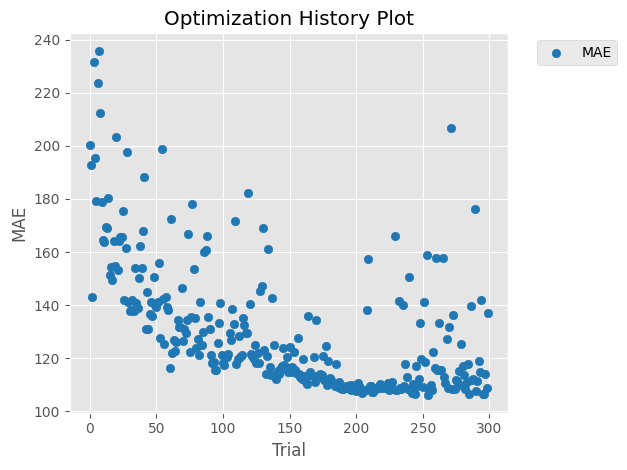

In [37]:
# ---------- 阶段 1：增强系数与近似条件 ----------
def objective_stage1(trial):
    low_bound = 80
    mid_bound = 160
    close_threshold = trial.suggest_int("close_threshold", 1, 10)
    enhance_coeffs = [trial.suggest_float(f"enhance{i}", 0.01, 0.8) for i in range(3)]
    reduce_coeffs = [trial.suggest_float(f"reduce{i}", 0.01, 0.8) for i in range(3)]
    thresholds = [83, 157, 234]  # 固定

    # 默认 R/G/B 参数
    R_params = [1] + [0.189, 0.139, 0.232] + [0.25, 0.097, 0.205, 0.332]
    G_params = [1] + [0.07, 0.04, 0.07] + [0.012, 0.123, 0.108, 0.051]
    B_params = [1] + [0.042, 0.012, 0.24] + [0.123, 0.262, 0.278, 0.037]

    params = (low_bound, mid_bound, close_threshold, enhance_coeffs, reduce_coeffs, thresholds,
              tuple(R_params), tuple(G_params), tuple(B_params))
    return compute_mae_and_smoothness(params)

def run_stage1(n_trials=200):
    study = optuna.create_study(directions=["minimize"])
    study.optimize(objective_stage1, n_trials=n_trials, show_progress_bar=True)
    best = min(study.best_trials, key=lambda t: t.values[0])
    print(f"Best MAE: {best.values[0]}")
    save_best_params(best, "less_param_multi_stage_save/stage1_params.csv")
    plot_history(study, "stage1")
    print("✅ 阶段 1 完成")

run_stage1(n_trials=300)

#### 阶段 2：阈值参数

🚀 阶段 2 开始


Best trial: 120. Best value: 101.291: 100%|██████████| 300/300 [00:19<00:00, 15.34it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_7716\2522487184.py:61: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_optimization_history(study, target=lambda t: t.values[0], target_name="MAE")


Best MAE: 101.29073972558055
✅ 阶段 2 完成


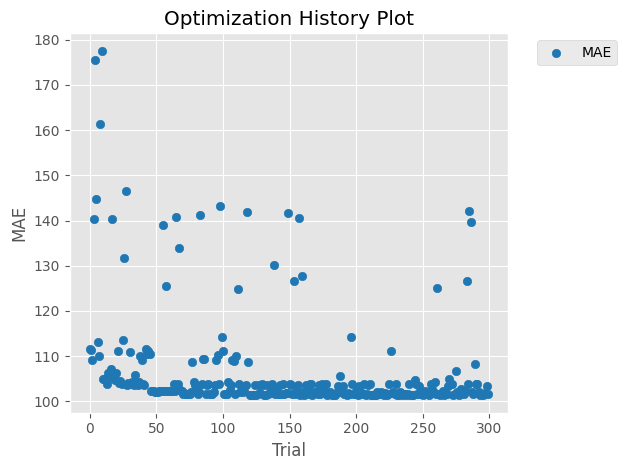

In [39]:
# ---------- 阶段 2：阈值参数 ----------
def objective_stage2(trial):
    p = load_params_from_json("less_param_multi_stage_save/stage1_params.json")
    
    threshold0 = trial.suggest_int("threshold0", 40, 120)
    threshold1 = trial.suggest_int("threshold1", threshold0 + 1, 200)
    threshold2 = trial.suggest_int("threshold2", threshold1 + 1, 255)
    thresholds = [threshold0, threshold1, threshold2]
    low_bound = trial.suggest_int("low_bound", 40, 150)
    mid_bound = trial.suggest_int("mid_bound", low_bound + 50, 255)
    close_threshold = p["close_threshold"]
    enhance_coeffs = [p[f"enhance{i}"] for i in range(3)]
    reduce_coeffs = [p[f"reduce{i}"] for i in range(3)]

    R_params = [1] + [0.189, 0.139, 0.232] + [0.25, 0.097, 0.205, 0.332]
    G_params = [1] + [0.07, 0.04, 0.07] + [0.012, 0.123, 0.108, 0.051]
    B_params = [1] + [0.042, 0.012, 0.24] + [0.123, 0.262, 0.278, 0.037]

    params = (low_bound, mid_bound, close_threshold, enhance_coeffs, reduce_coeffs, thresholds,
              tuple(R_params), tuple(G_params), tuple(B_params))
    return compute_mae_and_smoothness(params)

def run_stage2(n_trials=200):
    print("🚀 阶段 2 开始")
    study = optuna.create_study(directions=["minimize"])
    study.optimize(objective_stage2, n_trials=n_trials, show_progress_bar=True)
    best = min(study.best_trials, key=lambda t: t.values[0])
    print(f"Best MAE: {best.values[0]}")
    save_best_params(best, "less_param_multi_stage_save/stage2_params.csv")
    plot_history(study, "stage2")
    print("✅ 阶段 2 完成")

run_stage2(n_trials=300)

#### 阶段 3：R/G/B 参数

🚀 阶段 3 开始


Best trial: 299. Best value: 103.394: 100%|██████████| 300/300 [00:47<00:00,  6.27it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_7716\2522487184.py:61: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_optimization_history(study, target=lambda t: t.values[0], target_name="MAE")


Best MAE: 103.39377926724572
✅ 阶段 3 完成


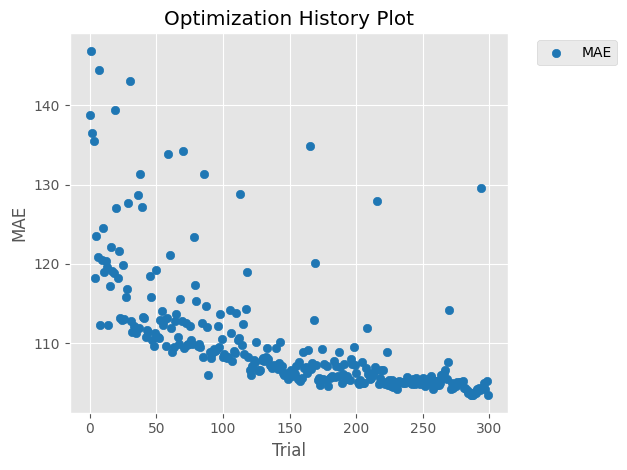

In [40]:
# ---------- 阶段 3：R/G/B 参数 ----------
def objective_stage3(trial):
    p = load_params_from_json("less_param_multi_stage_save/stage2_params.json")
    p1 = load_params_from_json("less_param_multi_stage_save/stage1_params.json")
    
    thresholds = [p[f"threshold{i}"] for i in range(3)]
    low_bound = p["low_bound"]
    mid_bound = p["mid_bound"]
    close_threshold = p1["close_threshold"]
    enhance_coeffs = [p1[f"enhance{i}"] for i in range(3)]
    reduce_coeffs = [p1[f"reduce{i}"] for i in range(3)]

    R_params = [1,
        trial.suggest_float("R_enh1", 0.01, 0.5),
        trial.suggest_float("R_enh2", 0.01, 0.5),
        trial.suggest_float("R_enh3", 0.01, 0.5),
        trial.suggest_float("R_red1", 0.01, 0.5),
        trial.suggest_float("R_red2", 0.01, 0.5),
        trial.suggest_float("R_red3", 0.01, 0.5),
        trial.suggest_float("R_red4", 0.01, 0.5)]

    G_params = [1,
        trial.suggest_float("G_enh1", 0.01, 0.1),
        trial.suggest_float("G_enh2", 0.01, 0.1),
        trial.suggest_float("G_enh3", 0.01, 0.1),
        trial.suggest_float("G_red1", 0.01, 0.1),
        trial.suggest_float("G_red2", 0.01, 0.1),
        trial.suggest_float("G_red3", 0.01, 0.1),
        trial.suggest_float("G_red4", 0.01, 0.1)]

    B_params = [1,
        trial.suggest_float("B_enh1", 0.01, 0.5),
        trial.suggest_float("B_enh2", 0.01, 0.5),
        trial.suggest_float("B_enh3", 0.01, 0.5),
        trial.suggest_float("B_red1", 0.01, 0.5),
        trial.suggest_float("B_red2", 0.01, 0.5),
        trial.suggest_float("B_red3", 0.01, 0.5),
        trial.suggest_float("B_red4", 0.01, 0.5)]

    params = (low_bound, mid_bound, close_threshold, enhance_coeffs, reduce_coeffs, thresholds,
              tuple(R_params), tuple(G_params), tuple(B_params))
    return compute_mae_and_smoothness(params)

def run_stage3(n_trials=200):
    print("🚀 阶段 3 开始")
    study = optuna.create_study(directions=["minimize"])
    study.optimize(objective_stage3, n_trials=n_trials, show_progress_bar=True)
    best = min(study.best_trials, key=lambda t: t.values[0])
    print(f"Best MAE: {best.values[0]}")
    save_best_params(best, "less_param_multi_stage_save/stage3_params.csv")
    plot_history(study, "stage3")
    print("✅ 阶段 3 完成")

run_stage3(n_trials=300)

#### 阶段 4：全局微调

🚀 阶段 4 开始


Best trial: 463. Best value: 92.4613: 100%|██████████| 500/500 [02:15<00:00,  3.69it/s]


Best MAE: 92.46131007621184


C:\Users\User\AppData\Local\Temp\ipykernel_7716\2522487184.py:61: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_optimization_history(study, target=lambda t: t.values[0], target_name="MAE")


✅ 阶段 4 完成


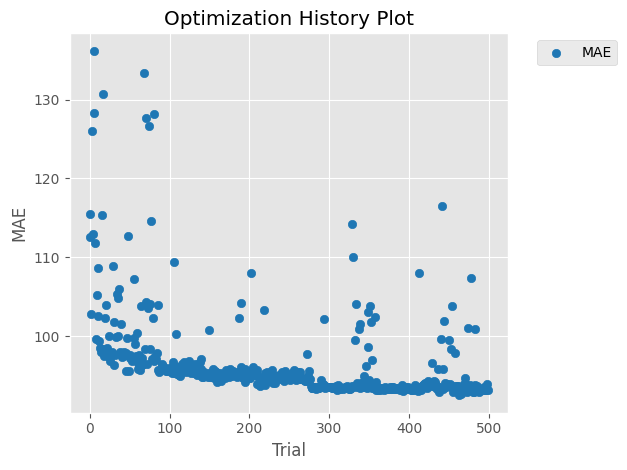

In [41]:
# ---------- 阶段 4：全局微调 ----------
def objective_stage4(trial):
    p = load_params_from_json("less_param_multi_stage_save/stage3_params.json")

    p2 = load_params_from_json("less_param_multi_stage_save/stage2_params.json")
    p1 = load_params_from_json("less_param_multi_stage_save/stage1_params.json")
    def vary(name, base, scale):
        return trial.suggest_float(name, base * (1 - scale), base * (1 + scale))

    thresholds = [int(vary(f"threshold{i}", p2[f"threshold{i}"], 0.1)) for i in range(3)]
    low_bound = int(vary("low_bound", p2["low_bound"], 0.1))
    mid_bound = int(vary("mid_bound", p2["mid_bound"], 0.1))
    close_threshold = int(vary("close_threshold", p1["close_threshold"], 0.2))
    enhance_coeffs = [vary(f"enhance{i}", p1[f"enhance{i}"], 0.2) for i in range(3)]
    reduce_coeffs = [vary(f"reduce{i}", p1[f"reduce{i}"], 0.2) for i in range(3)]

    R_params = [1] + [vary(f"R_enh{i+1}", p[f"R_enh{i+1}"], 0.2) for i in range(3)] + \
               [vary(f"R_red{i+1}", p[f"R_red{i+1}"], 0.2) for i in range(4)]
    G_params = [1] + [vary(f"G_enh{i+1}", p[f"G_enh{i+1}"], 0.2) for i in range(3)] + \
               [vary(f"G_red{i+1}", p[f"G_red{i+1}"], 0.2) for i in range(4)]
    B_params = [1] + [vary(f"B_enh{i+1}", p[f"B_enh{i+1}"], 0.2) for i in range(3)] + \
               [vary(f"B_red{i+1}", p[f"B_red{i+1}"], 0.2) for i in range(4)]

    params = (low_bound, mid_bound, close_threshold, enhance_coeffs, reduce_coeffs, thresholds,
              tuple(R_params), tuple(G_params), tuple(B_params))
    return compute_mae_and_smoothness(params)

def run_stage4(n_trials=200):
    print("🚀 阶段 4 开始")
    study = optuna.create_study(directions=["minimize"])
    study.optimize(objective_stage4, n_trials=n_trials, show_progress_bar=True)
    best = min(study.best_trials, key=lambda t: t.values[0])
    print(f"Best MAE: {best.values[0]}")
    save_best_params(best, "less_param_multi_stage_save/stage4_params.csv")
    plot_history(study, "stage4")
    print("✅ 阶段 4 完成")

run_stage4(n_trials=500)

#### 样例测试

In [42]:
best_params_for_analysis = load_params_from_json('less_param_multi_stage_save/stage4_params.json')
print_predictions(best_params_for_analysis)


Sample predictions:
Sample 1: input = ((24, 56, 57, 55)), Predicted = (0, 55, 57), Target = (0, 56, 56), Δ = (0, 1, 1)
Sample 2: input = ((11, 31, 33, 32)), Predicted = (0, 31, 33), Target = (0, 32, 32), Δ = (0, 1, 1)
Sample 3: input = ((28, 1, 31, 1)), Predicted = (28, 0, 31), Target = (32, 0, 32), Δ = (4, 0, 1)
Sample 4: input = ((42, 3, 47, 3)), Predicted = (42, 0, 47), Target = (48, 0, 48), Δ = (6, 0, 1)
Sample 5: input = ((65, 7, 72, 7)), Predicted = (65, 0, 72), Target = (72, 0, 72), Δ = (7, 0, 0)
Sample 6: input = ((72, 72, 17, 72)), Predicted = (72, 72, 0), Target = (72, 72, 0), Δ = (0, 0, 0)
Sample 7: input = ((56, 56, 11, 56)), Predicted = (56, 56, 0), Target = (56, 56, 0), Δ = (0, 0, 0)
Sample 8: input = ((24, 24, 2, 24)), Predicted = (24, 24, 0), Target = (24, 24, 0), Δ = (0, 0, 0)
Sample 9: input = ((214, 213, 73, 214)), Predicted = (216, 215, 0), Target = (216, 216, 0), Δ = (0, 1, 0)
Sample 10: input = ((245, 244, 85, 244)), Predicted = (247, 246, 0), Target = (248, 248,